In [1]:
# -*- coding: utf-8 -*-

# === KHÔNG THAY ĐỔI (Imports cơ bản và thêm thư viện cho HTR) ===
import os
import math # === THÊM: Thêm math để tính toán output width nếu cần ===

import pandas as pd
import numpy as np
# import sns # Không cần thiết cho HTR cơ bản
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models # <--- THAY ĐỔI: Thêm models
from torch.nn.utils.rnn import pad_sequence
from tqdm import tqdm
import gc
import matplotlib.pyplot as plt # Thêm để vẽ đồ thị loss (tùy chọn)
import json # Import json để lưu/tải map ký tự

# === THÊM: Kiểm tra và cảnh báo tương thích checkpoint ===
EXPECTED_ARCHITECTURE = "EfficientNetB0_CRNN" # Đặt tên cho kiến trúc mới

In [2]:
# === KHÔNG THAY ĐỔI (Thiết lập đường dẫn) ===
# Đường dẫn thư mục dữ liệu
data_dir = r"E:\HANDS-VNOnDB" # <--- KIỂM TRA LẠI ĐƯỜNG DẪN NÀY
label_file_path = os.path.join(data_dir, "reduced_normalized_InkData_word.csv") # <--- File chứa cả ID và label text
image_folder_original = os.path.join(data_dir, "reduced_Processed_Images_Words")

# Thư mục lưu ảnh đã xử lý (resize)
image_folder_processed = r"D:\HANDS-VNOnDB\Processed_Images_Words_HTR" 

In [3]:
# 3. Chuẩn hóa file gán nhãn

# def split_id(df, id_col="id"):
#     df[['document_id', 'line_id', 'word_id']] = df[id_col].str.rsplit('_', n=2, expand=True)
#     return df.head()

# print((pd.read_csv(os.path.join(data_dir, "normalized_InkData_line.csv"))))

In [4]:
TARGET_IMG_HEIGHT = 32
TARGET_IMG_WIDTH = 384 

In [5]:
def preprocess_image_htr(image_path, target_size=(TARGET_IMG_WIDTH, TARGET_IMG_HEIGHT)):
    """Mở ảnh, chuyển grayscale, resize."""
    try:
        with Image.open(image_path) as img:
            img_gray = img.convert('L')
            img_resized = img_gray.resize(target_size, Image.Resampling.LANCZOS)
        return img_resized
    except Exception as e:
        print(f"Lỗi khi mở hoặc xử lý ảnh {image_path}: {e}")
        return None

In [6]:
def process_and_save_images_htr(input_folder, output_folder, target_size=(TARGET_IMG_WIDTH, TARGET_IMG_HEIGHT)):
    """Tiền xử lý và lưu ảnh vào thư mục mới."""
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
        print(f"Đã tạo thư mục: {output_folder}")

    image_files = [f for f in os.listdir(input_folder) if f.endswith(('.png', '.jpg'))]
    print(f"Tìm thấy {len(image_files)} ảnh trong {input_folder}")

    processed_count = 0
    skipped_count = 0
    error_count = 0
    for img_file in tqdm(image_files, desc="Preprocessing images for HTR", unit="image"):
        img_path = os.path.join(input_folder, img_file)
        output_img_path = os.path.join(output_folder, img_file)

        if not os.path.exists(output_img_path):
            processed_img = preprocess_image_htr(img_path, target_size)
            if processed_img:
                try:
                    processed_img.save(output_img_path)
                    processed_count += 1
                except Exception as e:
                    print(f"Lỗi khi lưu ảnh {output_img_path}: {e}")
                    error_count += 1
            else:
                 error_count += 1 # Lỗi trong hàm preprocess_image_htr
        else:
            skipped_count += 1

    total_processed_or_skipped = processed_count + skipped_count
    print(f"Hoàn thành tiền xử lý:")
    print(f"- Đã xử lý mới: {processed_count}")
    print(f"- Bỏ qua (đã tồn tại): {skipped_count}")
    print(f"- Lỗi: {error_count}")
    print(f"- Tổng số ảnh trong thư mục output: {total_processed_or_skipped}")
    print(f"Ảnh đã xử lý được lưu tại: {output_folder}")

In [7]:
# Chạy tiền xử lý ảnh (chỉ chạy nếu thư mục processed chưa có hoặc muốn ghi đè)
run_preprocessing = True # Đặt thành False nếu đã chạy và không muốn chạy lại
if run_preprocessing:
    process_and_save_images_htr(image_folder_original, image_folder_processed, target_size=(TARGET_IMG_WIDTH, TARGET_IMG_HEIGHT))
else:
    print(f"Bỏ qua bước tiền xử lý ảnh, sử dụng ảnh tại: {image_folder_processed}")
    if not os.path.exists(image_folder_processed):
        print(f"CẢNH BÁO: Thư mục ảnh đã xử lý {image_folder_processed} không tồn tại nhưng run_preprocessing=False.")
        exit()


Tìm thấy 33224 ảnh trong E:\HANDS-VNOnDB\reduced_Processed_Images_Words


Preprocessing images for HTR: 100%|██████████| 33224/33224 [00:02<00:00, 13187.39image/s]

Hoàn thành tiền xử lý:
- Đã xử lý mới: 0
- Bỏ qua (đã tồn tại): 33224
- Lỗi: 0
- Tổng số ảnh trong thư mục output: 33224
Ảnh đã xử lý được lưu tại: D:\HANDS-VNOnDB\Processed_Images_Words_HTR


In [9]:
# === THAY ĐỔI (Load nhãn TEXT thay vì ID) ===
# Đọc file CSV chứa nhãn
try:
    labels_df = pd.read_csv(label_file_path)
    print(f"Đã đọc thành công file label: {label_file_path}")
    # print("5 dòng đầu tiên của labels_df:")
    # print(labels_df.head())
    if 'label' not in labels_df.columns or 'id' not in labels_df.columns:
        raise ValueError("File CSV phải chứa cột 'id' và 'label'.")
    # Xử lý giá trị NaN trong cột label (thay bằng chuỗi rỗng hoặc bỏ qua)
    labels_df['label'] = labels_df['label'].fillna('')
    print(f"Số lượng dòng trong file label: {len(labels_df)}")
except Exception as e:
    print(f"LỖI khi đọc hoặc kiểm tra file CSV: {e}")
    exit()

Đã đọc thành công file label: E:\HANDS-VNOnDB\reduced_normalized_InkData_word.csv
Số lượng dòng trong file label: 33224


In [10]:

# Hàm tải đường dẫn ảnh và nhãn TEXT, đảm bảo khớp ID và ảnh tồn tại
def load_image_paths_and_text_labels(processed_image_folder, labels_df):
    image_paths = []
    text_labels = []
    missing_images = 0
    valid_ids_from_df = set(labels_df['id'])
    processed_image_files = os.listdir(processed_image_folder)
    processed_ids = set(os.path.splitext(f)[0] for f in processed_image_files if f.endswith(('.png', '.jpg')))

    print(f"Số ID hợp lệ từ CSV: {len(valid_ids_from_df)}")
    print(f"Số ảnh tìm thấy trong thư mục đã xử lý: {len(processed_ids)}")

    # Lọc DataFrame để chỉ giữ lại các ID có ảnh tương ứng
    labels_df_filtered = labels_df[labels_df['id'].isin(processed_ids)].copy()
    print(f"Số lượng mẫu sau khi lọc (có cả ảnh và label): {len(labels_df_filtered)}")

    # Tạo dictionary từ ID sang label text (từ DataFrame đã lọc)
    id_to_label = pd.Series(labels_df_filtered.label.values, index=labels_df_filtered.id).to_dict()

    # Lặp qua các ID đã lọc để tạo list cuối cùng
    for img_id in tqdm(labels_df_filtered['id'], desc="Khớp ảnh và nhãn"):
        img_filename = f"{img_id}.png" # Hoặc .jpg nếu có
        img_path = os.path.join(processed_image_folder, img_filename)
        # Kiểm tra lại lần nữa (dù đã lọc)
        if os.path.exists(img_path):
            image_paths.append(img_path)
            text_labels.append(id_to_label[img_id])
        else:
             missing_images += 1 # Không nên xảy ra nếu lọc đúng

    if missing_images > 0:
        print(f"Cảnh báo: {missing_images} ảnh có trong df_filtered nhưng không tìm thấy file!")

    return image_paths, text_labels

In [11]:
# Tải dữ liệu
all_image_paths, all_text_labels = load_image_paths_and_text_labels(image_folder_processed, labels_df)

if not all_image_paths:
    print("Lỗi: Không tải được ảnh hoặc nhãn nào. Kiểm tra lại đường dẫn và file.")
    exit()

print(f"Đã tải thành công {len(all_image_paths)} cặp ảnh-nhãn.")
print("Ví dụ 5 nhãn đầu tiên:", all_text_labels[:5])

Số ID hợp lệ từ CSV: 33224
Số ảnh tìm thấy trong thư mục đã xử lý: 33224
Số lượng mẫu sau khi lọc (có cả ảnh và label): 33224


Khớp ảnh và nhãn: 100%|██████████| 33224/33224 [00:02<00:00, 16609.05it/s]

Đã tải thành công 33224 cặp ảnh-nhãn.
Ví dụ 5 nhãn đầu tiên: ['hội', 'Nhưng', 'những', 'kinh', 'cuộc']


In [12]:
# === THAY ĐỔI (Chia Train/Test cho dữ liệu HTR) ===
# Đường dẫn lưu file train/test sau khi chia
train_csv_path = os.path.join(data_dir, "train_htr_words.csv")
test_csv_path = os.path.join(data_dir, "test_htr_words.csv")
from sklearn.model_selection import train_test_split

X_train_paths, X_test_paths, y_train_text, y_test_text = train_test_split(
    all_image_paths, all_text_labels, test_size=0.2, random_state=42
)

print(f"Số lượng mẫu train: {len(X_train_paths)}")
print(f"Số lượng mẫu test: {len(X_test_paths)}")

try:
    # Tạo DataFrame và lưu train set
    train_data_to_save = pd.DataFrame({'image_path': X_train_paths, 'label': y_train_text})
    train_data_to_save.to_csv(train_csv_path, index=False, encoding='utf-8')
    print(f"Đã lưu tập train vào: {train_csv_path}")

    # Tạo DataFrame và lưu test set
    test_data_to_save = pd.DataFrame({'image_path': X_test_paths, 'label': y_test_text})
    test_data_to_save.to_csv(test_csv_path, index=False, encoding='utf-8')
    print(f"Đã lưu tập test vào: {test_csv_path}")
except Exception as e:
    print(f"Lỗi khi lưu file train/test CSV: {e}")


Số lượng mẫu train: 26579
Số lượng mẫu test: 6645
Đã lưu tập train vào: E:\HANDS-VNOnDB\train_htr_words.csv
Đã lưu tập test vào: E:\HANDS-VNOnDB\test_htr_words.csv


In [13]:
# === THAY ĐỔI (Tạo bộ ký tự và mã hóa nhãn cho HTR) ===

# Tìm tất cả các ký tự duy nhất từ tập train và test
all_texts_for_vocab = y_train_text + y_test_text
characters = set(char for text in all_texts_for_vocab for char in str(text))
characters = sorted(list(characters))

# Thêm ký tự đặc biệt 'blank' cho CTC Loss (thường ở index 0)
BLANK_TOKEN = '<blank>'
if BLANK_TOKEN not in characters:
    characters.insert(0, BLANK_TOKEN) # Đảm bảo blank ở vị trí 0

print(f"Tổng số ký tự (bao gồm blank): {len(characters)}")
# print("Bộ ký tự:", "".join(characters)) # Có thể rất dài

# Tạo từ điển ánh xạ
char_to_int = {char: i for i, char in enumerate(characters)}
int_to_char = {i: char for i, char in enumerate(characters)}

# Số lượng lớp cho mô hình = số ký tự
num_classes_htr = len(characters)
print(f"Số lớp đầu ra cho mô hình HTR: {num_classes_htr}")

# Hàm mã hóa text thành chuỗi số nguyên
def encode_text(text, char_to_int_map):
    return [char_to_int_map[char] for char in str(text) if char in char_to_int_map]

# Mã hóa nhãn train và test
y_train_encoded = [encode_text(text, char_to_int) for text in y_train_text]
y_test_encoded = [encode_text(text, char_to_int) for text in y_test_text]

# In thử vài mẫu đã mã hóa
print("\nVí dụ mã hóa:")
print("Nhãn gốc:", y_train_text[0])
print("Nhãn mã hóa:", y_train_encoded[0])
print("Giải mã lại:", "".join([int_to_char[i] for i in y_train_encoded[0]]))

Tổng số ký tự (bao gồm blank): 144
Số lớp đầu ra cho mô hình HTR: 144

Ví dụ mã hóa:
Nhãn gốc: xét
Nhãn mã hóa: [57, 70, 54]
Giải mã lại: xét


In [14]:
# --- THÊM CODE LƯU FILE ĐÃ MÃ HÓA ---
import json
from tqdm import tqdm # Đảm bảo tqdm đã được import
print("\nBắt đầu lưu file đã mã hóa và bản đồ ký tự...")

# Định nghĩa đường dẫn file lưu (cùng thư mục với train/test csv)
encoded_train_path = os.path.join(data_dir, "encoded_train_word_labels.json")
encoded_test_path = os.path.join(data_dir, "encoded_test_word_labels.json")
charmap_path = os.path.join(data_dir, "character_map.json")

try:
    # Lưu y_train_encoded
    with open(encoded_train_path, 'w', encoding='utf-8') as f_train:
        json.dump(y_train_encoded, f_train)
    print(f"Đã lưu nhãn train đã mã hóa vào: {encoded_train_path}")

    # Lưu y_test_encoded
    with open(encoded_test_path, 'w', encoding='utf-8') as f_test:
        json.dump(y_test_encoded, f_test)
    print(f"Đã lưu nhãn test đã mã hóa vào: {encoded_test_path}")

    # Lưu cả hai bản đồ ký tự vào một file
    # Chuyển key của int_to_char thành string để tương thích JSON
    int_to_char_str_keys = {str(k): v for k, v in int_to_char.items()}
    char_maps = {
        'char_to_int': char_to_int,
        'int_to_char': int_to_char_str_keys # Lưu phiên bản key là string
    }
    with open(charmap_path, 'w', encoding='utf-8') as f_map:
        # indent=4 để dễ đọc file JSON hơn
        # ensure_ascii=False để lưu đúng ký tự tiếng Việt
        json.dump(char_maps, f_map, ensure_ascii=False, indent=4)
    print(f"Đã lưu bản đồ ký tự vào: {charmap_path}")

except Exception as e:
    print(f"Lỗi khi lưu file JSON đã mã hóa: {e}")
# --- KẾT THÚC CODE LƯU FILE ---


Bắt đầu lưu file đã mã hóa và bản đồ ký tự...
Đã lưu nhãn train đã mã hóa vào: E:\HANDS-VNOnDB\encoded_train_word_labels.json
Đã lưu nhãn test đã mã hóa vào: E:\HANDS-VNOnDB\encoded_test_word_labels.json
Đã lưu bản đồ ký tự vào: E:\HANDS-VNOnDB\character_map.json


In [15]:
# === THAY ĐỔI: Tính toán CNN Output Width cho EfficientNet-B0 BỊ CẮT BỚT SỚM HƠN ===
# Cần chạy cell này TRƯỚC khi định nghĩa collate_fn và model

import traceback # Import traceback for more detailed error printing

# --- Helper function để lấy phần CNN bị cắt bớt SỚM HƠN ---
def get_truncated_efficientnet_features():
    """Tải EfficientNet-B0 và trả về phần features bị cắt bớt RẤT SỚM (ví dụ: tới block 2)."""
    # Tải cấu trúc (weights=None để nhanh)
    effnet_full_features = models.efficientnet_b0(weights=None).features
    # Chọn các block bạn muốn giữ lại. Ví dụ: block 0 đến 2 (3 block đầu tiên)
    # [:3] tương ứng với output của stage 2 (reduction factor 4)
    truncated_cnn = nn.Sequential(*list(effnet_full_features[:3]))
    return truncated_cnn
# ------------------------------------------------------------

def calculate_cnn_output_width(img_height, img_width):
    """
    Ước tính chiều rộng và số kênh output của CNN EfficientNet-B0 ĐÃ BỊ CẮT BỚT SỚM.
    """
    # Dự đoán fallback width và channels cho [:3]
    cnn_output_w = img_width // 4 # Ước tính width = input_width / 4
    cnn_output_c = 40 # Output channels của block 2 trong EffNetB0

    # ... (Phần try-except-finally giữ nguyên logic, chỉ thay đổi hàm gọi) ...
    effnet_features = None
    dummy_input = None
    output_features = None

    try:
        print("Xây dựng kiến trúc CNN bị cắt bớt SỚM HƠN (ví dụ: EffNetB0 features[:3])...")
        truncated_cnn = get_truncated_efficientnet_features() # Gọi hàm helper mới
        truncated_cnn.eval()
        print("Xây dựng CNN bị cắt bớt thành công.")

        dummy_input = torch.randn(1, 3, img_height, img_width)
        print(f"Tạo dummy input shape: {dummy_input.shape}")

        print("Đang chạy dummy input qua CNN bị cắt bớt...")
        with torch.no_grad():
            output_features = truncated_cnn(dummy_input)
        print("Chạy dummy input thành công.")

        cnn_output_c = output_features.shape[1]
        cnn_output_w = output_features.shape[3]

        print(f"--- Tính toán Output CNN (Truncated[:3] EfficientNet-B0) ---") # Cập nhật tiêu đề
        print(f"Input H={img_height}, W={img_width}")
        print(f"Output shape after TRUNCATED[:3] features: [N, C, H, W] = {output_features.shape}")
        print(f"===> Số kênh output của CNN (C_out): {cnn_output_c}")
        print(f"===> Chiều rộng output của CNN (W_out / SeqLen for RNN): {cnn_output_w}")
        print(f"---------------------------------------------------------\n")

    except Exception as e:
        # ... (Phần xử lý lỗi giữ nguyên) ...
        print(f"\nLỖI khi chạy dummy input qua CNN bị cắt bớt SỚM: {e}")
        traceback.print_exc()
        print(f"===> Sử dụng giá trị mặc định dự đoán: W={cnn_output_w}, C={cnn_output_c}")

    finally:
        # ... (Phần dọn dẹp giữ nguyên) ...
         if truncated_cnn is not None: del truncated_cnn
         if dummy_input is not None: del dummy_input
         if output_features is not None: del output_features
         gc.collect()
         if torch.cuda.is_available(): torch.cuda.empty_cache()

    # Return the calculated values
    return cnn_output_w, cnn_output_c

# --- Tính toán và gán giá trị toàn cục ---
if 'TARGET_IMG_HEIGHT' not in globals() or 'TARGET_IMG_WIDTH' not in globals():
     raise ValueError("TARGET_IMG_HEIGHT và TARGET_IMG_WIDTH chưa được định nghĩa!")

print("Bắt đầu tính toán CNN_OUTPUT_WIDTH và CNN_OUTPUT_CHANNELS cho CNN bị cắt bớt SỚM HƠN...")
CNN_OUTPUT_WIDTH, CNN_OUTPUT_CHANNELS = calculate_cnn_output_width(TARGET_IMG_HEIGHT, TARGET_IMG_WIDTH)
# Kiểm tra xem width đã đủ lớn chưa
if CNN_OUTPUT_WIDTH < 93: # So sánh với max label length
     print(f"\n!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!")
     print(f"CẢNH BÁO: CNN_OUTPUT_WIDTH ({CNN_OUTPUT_WIDTH}) vẫn nhỏ hơn max label length (93).")
     print(f"          CTC Loss có thể vẫn lỗi với các nhãn dài.")
     print(f"          Cân nhắc tăng TARGET_IMG_WIDTH hơn nữa hoặc dùng CNN khác.")
     print(f"!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!\n")
else:
     print(f"Đã tính toán xong: CNN_OUTPUT_WIDTH = {CNN_OUTPUT_WIDTH} (>= 93), CNN_OUTPUT_CHANNELS = {CNN_OUTPUT_CHANNELS}")


# CẬP NHẬT TÊN KIẾN TRÚC ĐỂ LƯU CHECKPOINT
EXPECTED_ARCHITECTURE = "EfficientNetB0_Truncated_Early_CRNN" # Tên mới hơn
print(f"Kiến trúc dự kiến cho checkpoint: {EXPECTED_ARCHITECTURE}")

Bắt đầu tính toán CNN_OUTPUT_WIDTH và CNN_OUTPUT_CHANNELS cho CNN bị cắt bớt SỚM HƠN...
Xây dựng kiến trúc CNN bị cắt bớt SỚM HƠN (ví dụ: EffNetB0 features[:3])...
Xây dựng CNN bị cắt bớt thành công.
Tạo dummy input shape: torch.Size([1, 3, 32, 384])
Đang chạy dummy input qua CNN bị cắt bớt...
Chạy dummy input thành công.
--- Tính toán Output CNN (Truncated[:3] EfficientNet-B0) ---
Input H=32, W=384
Output shape after TRUNCATED[:3] features: [N, C, H, W] = torch.Size([1, 24, 8, 96])
===> Số kênh output của CNN (C_out): 24
===> Chiều rộng output của CNN (W_out / SeqLen for RNN): 96
---------------------------------------------------------

Đã tính toán xong: CNN_OUTPUT_WIDTH = 96 (>= 93), CNN_OUTPUT_CHANNELS = 24
Kiến trúc dự kiến cho checkpoint: EfficientNetB0_Truncated_Early_CRNN


In [16]:
# === THAY ĐỔI: Transforms cho ảnh HTR sử dụng EfficientNet ===
# EfficientNet mong đợi ảnh 3 kênh và chuẩn hóa theo ImageNet

htr_transform = transforms.Compose([
    # Ảnh đã được resize và grayscale trong bước tiền xử lý trước đó
    # và được load bằng PIL trong Dataset (nên là mode 'L')

    # Chuyển PIL Image (mode 'L', H, W) [0-255] thành Tensor (1, H, W) [0, 1]
    transforms.ToTensor(),

    # Lặp lại kênh đơn thành 3 kênh để phù hợp EfficientNet input (3, H, W)
    transforms.Lambda(lambda x: x.repeat(3, 1, 1)),

    # Chuẩn hóa ImageNet cho 3 kênh
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

print("\nĐã định nghĩa htr_transform cho EfficientNet.")


Đã định nghĩa htr_transform cho EfficientNet.


In [17]:
# === THAY ĐỔI NHẸ: Class Dataset (Thêm xử lý lỗi và trả về None) ===
class CustomDatasetHTR(Dataset):
    def __init__(self, image_paths, encoded_labels, transform=None):
        # Đảm bảo số lượng paths và labels khớp nhau
        if len(image_paths) != len(encoded_labels):
            raise ValueError(f"Số lượng image_paths ({len(image_paths)}) không khớp với encoded_labels ({len(encoded_labels)})!")
        self.image_paths = image_paths
        self.encoded_labels = encoded_labels # List các list số nguyên
        self.transform = transform
        print(f"Khởi tạo CustomDatasetHTR với {len(self.image_paths)} mẫu.")

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        # Lấy path và label gốc (list số nguyên)
        img_path = self.image_paths[idx]
        label_list = self.encoded_labels[idx]

        # Chuyển đổi label thành tensor và kiểm tra rỗng sớm
        try:
            encoded_label_tensor = torch.tensor(label_list, dtype=torch.long)
            if len(encoded_label_tensor) == 0:
                 # Nhãn rỗng sau mã hóa, bỏ qua sample này
                 # print(f"Debug: Sample {idx} ({os.path.basename(img_path)}) has empty label list. Returning None.")
                 return None # collate_fn sẽ lọc bỏ
        except Exception as e:
             print(f"Lỗi khi chuyển label list thành tensor cho sample {idx} ({os.path.basename(img_path)}): {e}")
             print(f"Label list: {label_list}")
             return None # collate_fn sẽ lọc bỏ

        # Xử lý ảnh
        try:
            # Mở ảnh bằng Pillow (chế độ mặc định)
            image = Image.open(img_path)

            # Đảm bảo ảnh là Grayscale ('L') trước khi áp dụng transform
            if image.mode != 'L':
                 # print(f"Debug: Converting image {os.path.basename(img_path)} from mode {image.mode} to 'L'.")
                 image = image.convert('L')

            # Áp dụng transform (bao gồm ToTensor, repeat channels, Normalize)
            if self.transform:
                image_tensor = self.transform(image)
            else:
                 # Nếu không có transform, cần tự chuyển sang Tensor và xử lý kênh
                 # Nên luôn có transform cho model PyTorch
                 image_tensor = transforms.ToTensor()(image) # Chỉ chuyển thành Tensor (1, H, W)
                 # Cần xử lý kênh nếu không có transform lặp kênh
                 if image_tensor.shape[0] == 1:
                      image_tensor = image_tensor.repeat(3, 1, 1) # Lặp kênh thủ công

            # Trả về ảnh tensor và label tensor
            return image_tensor, encoded_label_tensor

        except FileNotFoundError:
             print(f"Lỗi: Không tìm thấy file ảnh tại {img_path} cho sample {idx}.")
             return None # collate_fn sẽ lọc bỏ
        except Exception as e:
            print(f"Lỗi khi tải hoặc transform ảnh {img_path} cho sample {idx}: {e}")
            import traceback
            # traceback.print_exc() # Bỏ comment để xem chi tiết lỗi nếu cần
            return None # collate_fn sẽ lọc bỏ

In [18]:
# === THAY ĐỔI: Hàm collate_fn với CNN_OUTPUT_WIDTH đã tính toán và lọc None ===

def collate_fn_htr(batch):
    # Lọc bỏ các sample bị lỗi (None) trả về từ __getitem__
    # batch là list các tuple (image_tensor, label_tensor) hoặc None
    original_batch_size = len(batch)
    batch = [item for item in batch if item is not None]
    filtered_batch_size = len(batch)

    # if original_batch_size != filtered_batch_size:
    #      print(f"Debug collate_fn: Filtered {original_batch_size - filtered_batch_size} None items from batch.")

    if not batch:
        # print("Warning: Collate function received an empty batch after filtering None items.")
        return None, None, None, None # Trả về None nếu cả batch bị lỗi

    try:
        # Tách ảnh và nhãn từ batch đã lọc
        images, labels = zip(*batch) # images là tuple các tensor ảnh, labels là tuple các tensor nhãn

        # Xếp chồng ảnh thành batch tensor (N, C, H, W) - Bây giờ C sẽ là 3
        images = torch.stack(images, 0)

        # Pad labels (labels đã là tensor từ __getitem__)
        # Tính độ dài trước khi pad
        label_lengths = torch.tensor([len(label) for label in labels], dtype=torch.long)

        # Lấy BLANK_TOKEN index từ char_to_int map (đảm bảo char_to_int đã tồn tại)
        if 'char_to_int' not in globals() or 'BLANK_TOKEN' not in globals():
             raise NameError("char_to_int hoặc BLANK_TOKEN chưa được định nghĩa!")
        blank_token_idx = char_to_int.get(BLANK_TOKEN, 0) # Mặc định là 0 nếu không tìm thấy

        # Thực hiện padding
        padded_labels = pad_sequence(labels, batch_first=True, padding_value=blank_token_idx)

        # Tính toán input lengths cho CTCLoss (chiều dài sequence từ CNN output)
        # Sử dụng giá trị CNN_OUTPUT_WIDTH đã tính toán tự động
        if 'CNN_OUTPUT_WIDTH' not in globals():
             raise NameError("Biến toàn cục CNN_OUTPUT_WIDTH chưa được tính toán!")
        # Kích thước batch hiện tại có thể nhỏ hơn BATCH_SIZE do lọc None
        current_batch_size = images.size(0)
        input_lengths = torch.full(size=(current_batch_size,), fill_value=CNN_OUTPUT_WIDTH, dtype=torch.long)

        # Kiểm tra độ dài hợp lệ (đề phòng lỗi CTC)
        if torch.any(label_lengths <= 0):
            print(f"Warning collate_fn: Batch contains labels with length <= 0.")
            # print(f"Label lengths in batch: {label_lengths}")
            # Có thể cần lọc lại batch ở đây nếu CTC không xử lý được
            # Hoặc đảm bảo Dataset không trả về nhãn rỗng

        return images, padded_labels, input_lengths, label_lengths

    except Exception as e:
        print(f"\n!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!")
        print(f"Lỗi nghiêm trọng trong collate_fn_htr: {e}")
        print(f"Kiểm tra lại dữ liệu đầu vào và logic padding.")
        # print(f"Batch size after filtering: {len(batch)}")
        # In thông tin các phần tử trong batch để debug
        # for i, item in enumerate(batch):
        #      if item is not None:
        #           print(f" Batch item {i}: Image shape {item[0].shape}, Label shape {item[1].shape}")
        #      else:
        #           print(f" Batch item {i}: None")
        print(f"!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!\n")
        import traceback
        traceback.print_exc()
        # Trả về None để bỏ qua batch này trong vòng lặp huấn luyện
        return None, None, None, None

# Chỉ in khi cell được chạy
if 'CNN_OUTPUT_WIDTH' in globals():
    print(f"\nĐã định nghĩa collate_fn_htr với CNN_OUTPUT_WIDTH = {CNN_OUTPUT_WIDTH}")
else:
    print("\nĐã định nghĩa collate_fn_htr, nhưng CNN_OUTPUT_WIDTH chưa được tính (chạy cell tính toán trước).")


Đã định nghĩa collate_fn_htr với CNN_OUTPUT_WIDTH = 96


In [19]:
# === KHÔNG THAY ĐỔI (Thử load dữ liệu đã mã hóa từ file JSON - tùy chọn) ===
# Cell này chủ yếu để xác nhận file đã lưu đúng, dữ liệu chính đã được mã hóa và lọc ở các cell trên.

print("\nKiểm tra và thử tải lại dữ liệu đã mã hóa từ file JSON (để xác nhận)...")
loaded_encoded_data_check = False # Flag kiểm tra
if os.path.exists(encoded_train_path) and \
   os.path.exists(encoded_test_path) and \
   os.path.exists(charmap_path):
    try:
        # Chỉ tải để kiểm tra, không ghi đè biến hiện tại trừ khi có lý do
        with open(encoded_train_path, 'r', encoding='utf-8') as f_train:
            _ = json.load(f_train) # Tải vào biến tạm
        with open(encoded_test_path, 'r', encoding='utf-8') as f_test:
            _ = json.load(f_test)
        with open(charmap_path, 'r', encoding='utf-8') as f_map:
            _ = json.load(f_map)

        print(f"Kiểm tra tải file JSON thành công: {encoded_train_path}, {encoded_test_path}, {charmap_path}")
        loaded_encoded_data_check = True

    except Exception as e:
        print(f"Lỗi khi kiểm tra tải file JSON đã mã hóa: {e}. Tiếp tục với dữ liệu trong bộ nhớ.")
else:
    print("Không tìm thấy một hoặc nhiều file JSON đã mã hóa/charmap để kiểm tra.")


Kiểm tra và thử tải lại dữ liệu đã mã hóa từ file JSON (để xác nhận)...
Kiểm tra tải file JSON thành công: E:\HANDS-VNOnDB\encoded_train_word_labels.json, E:\HANDS-VNOnDB\encoded_test_word_labels.json, E:\HANDS-VNOnDB\character_map.json


In [20]:
# === KHÔNG THAY ĐỔI (Tạo Dataset) ===
# Tạo Dataset và DataLoader mới với dữ liệu đã lọc và transform mới
# Đảm bảo X_train_paths, y_train_encoded, X_test_paths, y_test_encoded là các phiên bản đã lọc

# Kiểm tra lại dữ liệu trước khi tạo Dataset
if not X_train_paths or not y_train_encoded:
     print("Lỗi: Không có dữ liệu huấn luyện hợp lệ sau khi lọc. Không thể tạo Dataset.")
     # exit()
elif not X_test_paths or not y_test_encoded:
     print("Cảnh báo: Không có dữ liệu kiểm tra hợp lệ sau khi lọc. Tập test sẽ rỗng.")
     # Tạo test_dataset rỗng hoặc xử lý phù hợp
     test_dataset_htr = None # Hoặc dataset rỗng
else:
     print(f"\nSẵn sàng tạo Dataset với {len(X_train_paths)} mẫu train và {len(X_test_paths)} mẫu test.")


try:
    train_dataset_htr = CustomDatasetHTR(X_train_paths, y_train_encoded, transform=htr_transform)
    print(f"Đã tạo train_dataset_htr.")

    # Chỉ tạo test_dataset nếu có dữ liệu test
    if X_test_paths and y_test_encoded:
         test_dataset_htr = CustomDatasetHTR(X_test_paths, y_test_encoded, transform=htr_transform)
         print(f"Đã tạo test_dataset_htr.")
    else:
         print("Không có dữ liệu test hợp lệ, test_dataset_htr sẽ là None.")
         test_dataset_htr = None

except Exception as e:
     print(f"\nLỗi khi khởi tạo CustomDatasetHTR: {e}")
     print("Kiểm tra lại dữ liệu đầu vào (paths, labels) và class Dataset.")
     # exit()


Sẵn sàng tạo Dataset với 26579 mẫu train và 6645 mẫu test.
Khởi tạo CustomDatasetHTR với 26579 mẫu.
Đã tạo train_dataset_htr.
Khởi tạo CustomDatasetHTR với 6645 mẫu.
Đã tạo test_dataset_htr.


In [28]:
# === KHÔNG THAY ĐỔI (Tạo DataLoader) ===
# Điều chỉnh batch_size tùy theo bộ nhớ GPU/CPU
BATCH_SIZE = 32 # Giữ nguyên hoặc giảm nếu gặp lỗi CUDA out of memory
NUM_WORKERS = 0 # Đặt là 0 để dễ debug, tăng lên (ví dụ 2 hoặc 4) để tăng tốc độ nếu không có lỗi

print(f"\nĐang tạo DataLoaders với batch_size={BATCH_SIZE}, num_workers={NUM_WORKERS}...")

# Tạo train_loader
if 'train_dataset_htr' in globals() and train_dataset_htr is not None and len(train_dataset_htr) > 0:
    train_loader_htr = DataLoader(
        train_dataset_htr,
        batch_size=BATCH_SIZE,
        shuffle=True,
        collate_fn=collate_fn_htr, # Sử dụng collate function đã định nghĩa
        num_workers=NUM_WORKERS,
        pin_memory=True if torch.cuda.is_available() else False # Pin memory nếu dùng CUDA
    )
    print(f"Đã tạo train_loader_htr với {len(train_loader_htr)} batches.")
else:
     print("Lỗi: train_dataset_htr không hợp lệ hoặc rỗng. Không thể tạo train_loader.")
     train_loader_htr = None # Đặt là None để xử lý lỗi sau


# Tạo test_loader (chỉ nếu test_dataset hợp lệ)
if 'test_dataset_htr' in globals() and test_dataset_htr is not None and len(test_dataset_htr) > 0:
    test_loader_htr = DataLoader(
        test_dataset_htr,
        batch_size=BATCH_SIZE,
        shuffle=False, # Không cần shuffle test set
        collate_fn=collate_fn_htr,
        num_workers=NUM_WORKERS,
        pin_memory=True if torch.cuda.is_available() else False
    )
    print(f"Đã tạo test_loader_htr với {len(test_loader_htr)} batches.")
else:
     print("test_dataset_htr không hợp lệ hoặc rỗng. test_loader_htr sẽ là None.")
     test_loader_htr = None





Đang tạo DataLoaders với batch_size=32, num_workers=0...
Đã tạo train_loader_htr với 831 batches.
Đã tạo test_loader_htr với 208 batches.


In [29]:
# === THAY ĐỔI: Định nghĩa mô hình CRNN với EfficientNet-B0 BỊ CẮT BỚT SỚM HƠN ===
class CRNN(nn.Module):
    def __init__(self, num_classes, rnn_hidden_size=256, rnn_num_layers=2, dropout=0.5):
        super(CRNN, self).__init__()

        # --- Phần CNN: Sử dụng EfficientNet-B0 Pre-trained BỊ CẮT BỚT SỚM HƠN ---
        weights = models.EfficientNet_B0_Weights.IMAGENET1K_V1
        effnet_full = models.efficientnet_b0(weights=weights)

        # Xây dựng CNN bị cắt bớt SỚM HƠN (phải giống hệt cell tính toán width)
        # Ví dụ: lấy 3 block đầu tiên (index 0 đến 2) -> features[:3]
        self.cnn = nn.Sequential(*list(effnet_full.features[:3]))
        print("Đã xây dựng CNN bị cắt bớt SỚM HƠN từ EfficientNet-B0 pre-trained.")

        # Lấy số kênh output từ CNN đã tính toán trước đó
        if 'CNN_OUTPUT_CHANNELS' not in globals():
             raise NameError("Biến toàn cục CNN_OUTPUT_CHANNELS chưa được tính toán!")
        self.cnn_output_channels = CNN_OUTPUT_CHANNELS # Sẽ là output của block 2 (40)

        # --- Adaptive Pooling để đảm bảo H_out = 1 ---
        self.adaptive_pool = nn.AdaptiveAvgPool2d((1, None))

        # --- Phần RNN ---
        print(f"Input size cho LSTM sẽ là: {self.cnn_output_channels}") # Kênh ít hơn
        self.rnn = nn.LSTM(self.cnn_output_channels, rnn_hidden_size, rnn_num_layers,
                           bidirectional=True, batch_first=False, dropout=dropout if rnn_num_layers > 1 else 0)

        self.dropout_rnn_out = nn.Dropout(dropout)

        # --- Phần Fully Connected ---
        self.fc = nn.Linear(rnn_hidden_size * 2, num_classes)

        print("--- Khởi tạo CRNN với EfficientNet-B0 BỊ CẮT BỚT SỚM HƠN ---")
        print(f"CNN Backbone: Truncated EfficientNet-B0 Features (ví dụ: [:3])") # Cập nhật mô tả
        print(f"CNN Output Channels (to RNN): {self.cnn_output_channels}")
        print(f"CNN Output Width (SeqLen for RNN - đã tính): {CNN_OUTPUT_WIDTH}") # In ra để kiểm tra
        # ... (Các thông số RNN/Dropout giữ nguyên) ...
        print(f"RNN Hidden Size: {rnn_hidden_size}")
        print(f"RNN Num Layers: {rnn_num_layers}")
        print(f"Output Classes (incl. blank): {num_classes}")
        print("------------------------------------------------------")

        del effnet_full
        gc.collect()

    def forward(self, x):
        # ... (Logic forward giữ nguyên như trước) ...
        features = self.cnn(x)
        features = self.adaptive_pool(features)
        features = features.squeeze(2)
        features = features.permute(2, 0, 1)
        self.rnn.flatten_parameters()
        rnn_output, _ = self.rnn(features)
        rnn_output = self.dropout_rnn_out(rnn_output)
        output = self.fc(rnn_output)
        return output

In [30]:
# === THAY ĐỔI: Khởi tạo model CRNN mới, kiểm tra device và forward ===
# Kiểm tra device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"\nSử dụng device: {device}")

# Khởi tạo model CRNN với backbone EfficientNet
# Đảm bảo num_classes_htr đã được tính toán chính xác
if 'num_classes_htr' not in globals():
     raise NameError("Biến num_classes_htr chưa được định nghĩa!")

print(f"Khởi tạo model CRNN (EfficientNet) với {num_classes_htr} lớp đầu ra.")
model_htr = CRNN(num_classes=num_classes_htr) # Các tham số RNN/dropout dùng default
model_htr = model_htr.to(device)
print("Khởi tạo mô hình CRNN (EfficientNet Backbone) thành công.")




Sử dụng device: cpu
Khởi tạo model CRNN (EfficientNet) với 144 lớp đầu ra.
Đã xây dựng CNN bị cắt bớt SỚM HƠN từ EfficientNet-B0 pre-trained.
Input size cho LSTM sẽ là: 24
--- Khởi tạo CRNN với EfficientNet-B0 BỊ CẮT BỚT SỚM HƠN ---
CNN Backbone: Truncated EfficientNet-B0 Features (ví dụ: [:3])
CNN Output Channels (to RNN): 24
CNN Output Width (SeqLen for RNN - đã tính): 96
RNN Hidden Size: 256
RNN Num Layers: 2
Output Classes (incl. blank): 144
------------------------------------------------------
Khởi tạo mô hình CRNN (EfficientNet Backbone) thành công.


In [31]:
# === THAY ĐỔI: Loss, Optimizer, Checkpoint handling (Cập nhật tên checkpoint và architecture) ===

# ... (Phần định nghĩa criterion, optimizer giữ nguyên) ...
if 'char_to_int' not in globals() or 'BLANK_TOKEN' not in globals(): #... (Kiểm tra blank_idx) ...
    raise NameError("char_to_int hoặc BLANK_TOKEN chưa được định nghĩa!")
blank_idx = char_to_int.get(BLANK_TOKEN)
if blank_idx is None: raise ValueError(f"'{BLANK_TOKEN}' không tìm thấy trong char_to_int!")
criterion_htr = nn.CTCLoss(blank=blank_idx, reduction='mean', zero_infinity=True)
print(f"\nĐã khởi tạo CTCLoss với blank index = {blank_idx}")

INITIAL_LR = 5e-4
optimizer_htr = optim.AdamW(model_htr.parameters(), lr=INITIAL_LR, weight_decay=1e-1)
print(f"Đã khởi tạo Optimizer AdamW với LR = {INITIAL_LR}")


# --- CẬP NHẬT CHECKPOINT PATH VÀ ARCHITECTURE NAME ---
CHECKPOINT_DIR = r"G:\Compvision Final\pythonProject"
os.makedirs(CHECKPOINT_DIR, exist_ok=True)
# Đổi tên file để phân biệt với kiến trúc TRUNCATED SỚM
CHECKPOINT_FILENAME = "checkpoint_htr_word_effnet_trunc_early.pth" # Tên file mới hơn
CHECKPOINT_PATH_HTR = os.path.join(CHECKPOINT_DIR, CHECKPOINT_FILENAME)
# Sử dụng EXPECTED_ARCHITECTURE đã cập nhật ở cell tính toán width
print(f"Kiến trúc dự kiến: {EXPECTED_ARCHITECTURE}")
print(f"Đường dẫn checkpoint mới: {CHECKPOINT_PATH_HTR}")
# ----------------------------------------------------

# Training parameters
START_EPOCH_HTR = 0
NUM_EPOCHS = 5 # Đặt số epoch bạn muốn
train_losses = []
val_losses = [] # Vẫn giữ nếu bạn muốn thêm lại validation sau này

# --- Load Checkpoint nếu có VÀ KIẾN TRÚC PHÙ HỢP (DÙNG TÊN MỚI NHẤT) ---
if os.path.exists(CHECKPOINT_PATH_HTR):
    print(f"\nTìm thấy checkpoint tại: {CHECKPOINT_PATH_HTR}")
    try:
        checkpoint = torch.load(CHECKPOINT_PATH_HTR, map_location=device)
        print("Tải file checkpoint thành công.")
        # ... (Phần kiểm tra architecture và load state dict giữ nguyên logic như cell trước) ...
        loaded_architecture = checkpoint.get('architecture')
        if loaded_architecture != EXPECTED_ARCHITECTURE:
             print(f"\nCẢNH BÁO: Checkpoint '{loaded_architecture}' != Hiện tại '{EXPECTED_ARCHITECTURE}'. Bắt đầu lại.")
             START_EPOCH_HTR = 0
        else:
             print(f"Kiến trúc checkpoint khớp. Đang tải trạng thái...")
             # ... (load state dicts, epoch, losses, kiểm tra CNN width) ...
             try:
                 model_htr.load_state_dict(checkpoint['model_state_dict'])
                 optimizer_htr.load_state_dict(checkpoint['optimizer_state_dict'])
                 START_EPOCH_HTR = checkpoint.get('epoch', -1) + 1
                 train_losses = checkpoint.get('train_losses', [])
                 loaded_cnn_output_width = checkpoint.get('cnn_output_width', -1)
                 if loaded_cnn_output_width != -1 and loaded_cnn_output_width != CNN_OUTPUT_WIDTH:
                      print(f"\nCẢNH BÁO: Width checkpoint ({loaded_cnn_output_width}) != hiện tại ({CNN_OUTPUT_WIDTH})!")
                 print(f"\n===> Đã tải checkpoint. Tiếp tục huấn luyện từ epoch {START_EPOCH_HTR}")
             except (KeyError, RuntimeError) as e_load:
                 print(f"\nLỗi khi tải state_dict: {e_load}. Bắt đầu lại.")
                 START_EPOCH_HTR = 0; train_losses = []
                 # Khởi tạo lại nếu cần
                 if 'model_htr' not in locals(): model_htr = CRNN(num_classes=num_classes_htr).to(device)
                 if 'optimizer_htr' not in locals(): optimizer_htr = optim.AdamW(model_htr.parameters(), lr=INITIAL_LR, weight_decay=5e-4)

    except Exception as e:
        print(f"\nLỗi không xác định khi tải checkpoint: {e}. Bắt đầu lại.")
        START_EPOCH_HTR = 0; train_losses = []
        # Khởi tạo lại nếu cần
        if 'model_htr' not in locals(): model_htr = CRNN(num_classes=num_classes_htr).to(device)
        if 'optimizer_htr' not in locals(): optimizer_htr = optim.AdamW(model_htr.parameters(), lr=INITIAL_LR, weight_decay=5e-4)
else:
    print(f"\nKhông tìm thấy checkpoint tại {CHECKPOINT_PATH_HTR}. Bắt đầu huấn luyện từ đầu (epoch 1).")

# Dọn dẹp
if 'checkpoint' in locals(): del checkpoint
gc.collect()
if torch.cuda.is_available(): torch.cuda.empty_cache()


Đã khởi tạo CTCLoss với blank index = 0
Đã khởi tạo Optimizer AdamW với LR = 0.0005
Kiến trúc dự kiến: EfficientNetB0_Truncated_Early_CRNN
Đường dẫn checkpoint mới: G:\Compvision Final\pythonProject\checkpoint_htr_word_effnet_trunc_early.pth

Không tìm thấy checkpoint tại G:\Compvision Final\pythonProject\checkpoint_htr_word_effnet_trunc_early.pth. Bắt đầu huấn luyện từ đầu (epoch 1).


In [32]:
# === KHÔNG THAY ĐỔI (Hàm giải mã Greedy) ===
def decode_batch(outputs, int_to_char_map, blank_token_idx):
    """
    Giải mã output của model (sau FC layer) thành chuỗi text sử dụng Greedy search.
    Args:
        outputs (torch.Tensor): Tensor output từ model. Shape: (SeqLen, Batch, NumClasses)
        int_to_char_map (dict): Map từ index sang ký tự.
        blank_token_idx (int): Index của blank token.
    Returns:
        list[str]: Danh sách các chuỗi text đã giải mã cho batch.
    """
    # Lấy argmax theo chiều class (dim=2) -> Shape: (SeqLen, Batch)
    # Chuyển sang CPU để xử lý numpy/list dễ hơn
    preds = torch.argmax(outputs.detach().cpu(), dim=2)
    # Chuyển vị thành (Batch, SeqLen)
    preds = preds.permute(1, 0).numpy()

    decoded_texts = []
    for pred_seq in preds:
        text = []
        last_char_idx = -1 # Dùng index thay vì ký tự để so sánh
        for idx in pred_seq:
            # Bỏ qua blank token và các ký tự lặp lại liên tiếp
            if idx != blank_token_idx and idx != last_char_idx:
                char = int_to_char_map.get(idx)
                if char: # Chỉ thêm nếu ký tự tồn tại trong map
                    text.append(char)
            last_char_idx = idx # Luôn cập nhật last_char_idx
        decoded_texts.append("".join(text))
    return decoded_texts

In [26]:
# from torch.optim.lr_scheduler import StepLR
# scheduler = StepLR(optimizer_htr, step_size=3, gamma=0.7)


Bắt đầu huấn luyện từ epoch 1 đến 5 (KHÔNG Validation)

===== Epoch 1/5 =====


Epoch 1 [Train]: 100%|██████████| 831/831 [11:10<00:00,  1.24batch/s, loss=3.7326, lr=5.0e-04]


Epoch 1 [Train] Average Loss: 5.0878 (831 batches)

===== Epoch 2/5 =====


Epoch 2 [Train]: 100%|██████████| 831/831 [09:12<00:00,  1.50batch/s, loss=3.6823, lr=5.0e-04]


Epoch 2 [Train] Average Loss: 3.4976 (831 batches)

===== Epoch 3/5 =====


Epoch 3 [Train]: 100%|██████████| 831/831 [09:46<00:00,  1.42batch/s, loss=2.6887, lr=5.0e-04]


Epoch 3 [Train] Average Loss: 3.0092 (831 batches)

===== Epoch 4/5 =====


Epoch 4 [Train]: 100%|██████████| 831/831 [07:30<00:00,  1.84batch/s, loss=1.7062, lr=5.0e-04]


Epoch 4 [Train] Average Loss: 2.3842 (831 batches)

===== Epoch 5/5 =====


Epoch 5 [Train]: 100%|██████████| 831/831 [07:17<00:00,  1.90batch/s, loss=2.6059, lr=5.0e-04]


Epoch 5 [Train] Average Loss: 1.9923 (831 batches)

===== Hoàn thành huấn luyện (Không có validation)! =====
Đã lưu đồ thị loss vào: G:\Compvision Final\pythonProject\loss_plot_EfficientNetB0_Truncated_Early_CRNN_train_only.png


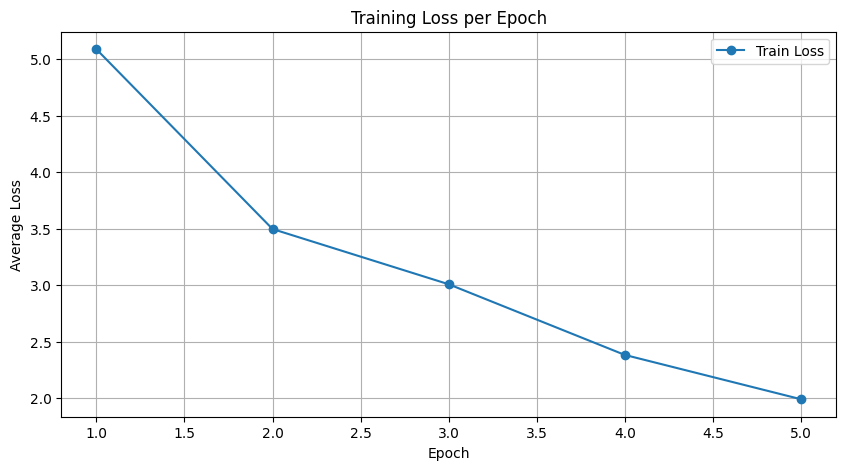

In [33]:
# === THAY ĐỔI: Vòng lặp Huấn luyện (BỎ HOÀN TOÀN VALIDATION) ===

# Kiểm tra DataLoader trước khi bắt đầu
if not train_loader_htr:
     print("\nLỗi: train_loader_htr không hợp lệ. Không thể bắt đầu huấn luyện.")
     exit() # Nên dừng ở đây nếu không có dữ liệu huấn luyện

print(f"\nBắt đầu huấn luyện từ epoch {START_EPOCH_HTR + 1} đến {NUM_EPOCHS} (KHÔNG Validation)")

# Reset lại list loss nếu bắt đầu từ đầu
if START_EPOCH_HTR == 0:
    train_losses = []
    # val_losses = [] # Không cần val_losses nữa


for epoch in range(START_EPOCH_HTR, NUM_EPOCHS):
    epoch_num = epoch + 1
    print(f"\n===== Epoch {epoch_num}/{NUM_EPOCHS} =====")

    # --- Training Phase ---
    model_htr.train() # Đặt model ở chế độ training
    running_loss = 0.0
    num_train_samples_processed = 0
    train_batches_processed = 0

    train_progress_bar = tqdm(train_loader_htr, desc=f"Epoch {epoch_num} [Train]", unit="batch")

    for batch_idx, batch_data in enumerate(train_progress_bar):
        # Kiểm tra xem collate_fn có trả về None không
        if batch_data is None or batch_data[0] is None:
            continue # Bỏ qua batch không hợp lệ

        images, padded_labels, input_lengths, label_lengths = batch_data
        current_batch_size = images.size(0)

        # Chuyển dữ liệu lên device
        images = images.to(device)
        padded_labels = padded_labels.to(device)
        input_lengths = input_lengths.to(device)
        label_lengths = label_lengths.to(device)

        # --- Forward pass ---
        optimizer_htr.zero_grad()
        outputs = model_htr(images) # output shape: (SeqLen, Batch, NumClasses)

        # --- Calculate CTC Loss ---
        log_probs = nn.functional.log_softmax(outputs, dim=2)

        # Điều chỉnh input lengths nếu cần (dù không nên xảy ra nếu CNN_OUTPUT_WIDTH đúng)
        valid_input_lengths = torch.clamp(input_lengths, max=log_probs.shape[0])
        # Đảm bảo label_lengths > 0
        valid_label_lengths = torch.clamp(label_lengths, min=1)

        # Tính loss
        try:
            loss = criterion_htr(log_probs, padded_labels, valid_input_lengths, valid_label_lengths)

            if torch.isnan(loss) or torch.isinf(loss):
                print(f"\nWarning: NaN/Inf loss in train batch {batch_idx}. Skipping backward pass.")
                continue

            # --- Backward pass and Optimization ---
            loss.backward()
            optimizer_htr.step()

            # Tích lũy loss
            running_loss += loss.item() * current_batch_size
            num_train_samples_processed += current_batch_size
            train_batches_processed += 1

            # Cập nhật thanh progress bar
            train_progress_bar.set_postfix(loss=f"{loss.item():.4f}", lr=f"{optimizer_htr.param_groups[0]['lr']:.1e}")

        except RuntimeError as rte:
             if "targets must be shorter than the T dimension" in str(rte):
                  # print(f"\nLỗi CTC trong train batch {batch_idx}: Target length > Input length. Skipping.") # Có thể bật để debug
                  # print(f"  Input lengths (max {log_probs.shape[0]}): {valid_input_lengths.tolist()}")
                  # print(f"  Target lengths: {valid_label_lengths.tolist()}")
                  continue
             else:
                  print(f"\nLỗi RuntimeError trong training step (batch {batch_idx}): {rte}")
                  traceback.print_exc()
                  continue
        except Exception as e:
            print(f"\nLỗi không xác định trong training step (batch {batch_idx}): {e}")
            traceback.print_exc()
            continue

    # Tính loss trung bình cho epoch training
    if num_train_samples_processed > 0:
        avg_train_loss = running_loss / num_train_samples_processed
        train_losses.append(avg_train_loss)
        print(f"Epoch {epoch_num} [Train] Average Loss: {avg_train_loss:.4f} ({train_batches_processed} batches)")
    else:
        print(f"Epoch {epoch_num} [Train] No batches processed successfully.")
        train_losses.append(float('inf')) # Ghi nhận lỗi nếu không có batch nào thành công


    # --- KHÔNG CÓ VALIDATION PHASE ---


    # --- Adjust Learning Rate (Optional - Không dựa vào val_loss) ---
    # Ví dụ: Giảm LR sau một số epoch cố định
    # if 'scheduler' in locals() and isinstance(scheduler, optim.lr_scheduler.StepLR):
    #      scheduler.step()
    #      print(f"Current LR: {optimizer_htr.param_groups[0]['lr']:.1e}")


    # --- Lưu Checkpoint SAU MỖI EPOCH ---
    # Chỉ lưu checkpoint cuối cùng của epoch đó
    checkpoint_data = {
        'epoch': epoch,
        'architecture': EXPECTED_ARCHITECTURE,
        'model_state_dict': model_htr.state_dict(),
        'optimizer_state_dict': optimizer_htr.state_dict(),
        'char_to_int': char_to_int,
        'train_losses': train_losses,
        # 'val_losses': [], # Không lưu val_losses
        # 'best_val_loss': float('inf'), # Không lưu best_val_loss
        'target_img_width': TARGET_IMG_WIDTH,
        'target_img_height': TARGET_IMG_HEIGHT,
        'cnn_output_width': CNN_OUTPUT_WIDTH
    }
    try:
        torch.save(checkpoint_data, CHECKPOINT_PATH_HTR)
        # Bỏ comment dòng dưới nếu muốn thấy log lưu mỗi epoch
        # print(f"Checkpoint saved after epoch {epoch_num} to {CHECKPOINT_PATH_HTR}")
    except Exception as e_save:
         print(f"Lỗi khi lưu checkpoint tại epoch {epoch_num}: {e_save}")


# --- Kết thúc vòng lặp huấn luyện ---
print("\n===== Hoàn thành huấn luyện (Không có validation)! =====")

# Vẽ đồ thị loss (chỉ có train loss)
if train_losses:
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, len(train_losses) + 1), train_losses, label='Train Loss', marker='o')
    plt.xlabel('Epoch')
    plt.ylabel('Average Loss')
    plt.title('Training Loss per Epoch')
    plt.legend()
    plt.grid(True)
    # Lưu đồ thị nếu muốn
    loss_plot_path = os.path.join(CHECKPOINT_DIR, f"loss_plot_{EXPECTED_ARCHITECTURE}_train_only.png")
    try:
        plt.savefig(loss_plot_path)
        print(f"Đã lưu đồ thị loss vào: {loss_plot_path}")
    except Exception as e_plot:
        print(f"Lỗi khi lưu đồ thị loss: {e_plot}")
    plt.show()
else:
    print("Không có dữ liệu train loss để vẽ đồ thị.")

In [34]:
print(f"DEBUG: Batch {batch_idx}, LogProbs SeqLen: {log_probs.shape[0]}, InputLengths Max: {valid_input_lengths.max().item()}, LabelLengths Max: {valid_label_lengths.max().item()}")

DEBUG: Batch 830, LogProbs SeqLen: 96, InputLengths Max: 96, LabelLengths Max: 5


In [35]:
# === KHÔNG THAY ĐỔI (Import jiwer để đánh giá) ===
try:
    import jiwer
    print("jiwer library imported successfully.")
    # Định nghĩa transformation cơ bản cho jiwer (thường là lowercase và bỏ dấu câu)
    jiwer_transform = jiwer.Compose([
        jiwer.ToLowerCase(),
        jiwer.RemoveMultipleSpaces(),
        # jiwer.RemovePunctuation(),
        jiwer.Strip()
    ])
    print("Defined basic jiwer transformation.")
except ImportError:
    print("Lỗi: Thư viện jiwer chưa được cài đặt.")
    print("Vui lòng cài đặt bằng lệnh: pip install jiwer")
    jiwer = None # Đặt là None để kiểm tra trước khi sử dụng
    jiwer_transform = None

jiwer library imported successfully.
Defined basic jiwer transformation.


In [36]:
# === KHÔNG THAY ĐỔI (Hàm giải mã nhãn gốc từ dạng padded) ===
def decode_padded_labels(padded_labels, label_lengths, int_to_char_map):
    """
    Chuyển đổi batch label đã được pad và tensor độ dài tương ứng
    thành một list các chuỗi text gốc.
    Args:
        padded_labels (torch.Tensor): Shape: (Batch, MaxLength). Nên ở trên CPU.
        label_lengths (torch.Tensor): Shape: (Batch,). Nên ở trên CPU.
        int_to_char_map (dict): Map từ index sang ký tự.
    Returns:
        list[str]: List các chuỗi text gốc đã được giải mã.
    """
    ground_truth_texts = []
    padded_labels_cpu = padded_labels.cpu()
    label_lengths_cpu = label_lengths.cpu()
    for i in range(padded_labels_cpu.size(0)):
        actual_len = label_lengths_cpu[i].item()
        if actual_len > 0:
            label_indices = padded_labels_cpu[i][:actual_len].tolist()
            try:
                text = "".join([int_to_char_map.get(idx, '') for idx in label_indices])
                ground_truth_texts.append(text)
            except Exception as e:
                print(f"Error decoding GT indices sample {i}: {e}")
                ground_truth_texts.append("[DECODING ERROR GT]")
        else:
             ground_truth_texts.append("")
    return ground_truth_texts

In [37]:
# === VIẾT LẠI: Đánh giá cuối cùng trên tập Test ===

print("\n===== Bắt đầu Đánh giá Cuối cùng trên Tập Test =====")

# --- Khởi tạo biến cho đánh giá ---
model_to_evaluate = None
checkpoint_loaded_successfully = False
char_to_int_eval = None
int_to_char_eval = None
blank_idx_eval = None
num_classes_eval = None

# --- Kiểm tra điều kiện tiên quyết ---
if jiwer is None:
    print("Lỗi: Thư viện jiwer không khả dụng.")
elif 'test_loader_htr' not in globals() or test_loader_htr is None:
    print("Lỗi: test_loader_htr không được định nghĩa hoặc rỗng.")
elif 'CHECKPOINT_PATH_HTR' not in globals() or not CHECKPOINT_PATH_HTR:
    print("Lỗi: Đường dẫn checkpoint CHECKPOINT_PATH_HTR chưa được định nghĩa.")
elif 'EXPECTED_ARCHITECTURE' not in globals() or not EXPECTED_ARCHITECTURE:
    print("Lỗi: Tên kiến trúc EXPECTED_ARCHITECTURE chưa được định nghĩa.")
elif 'CRNN' not in globals() or not callable(CRNN):
     print("Lỗi: Class CRNN chưa được định nghĩa.")
elif 'BLANK_TOKEN' not in globals():
     print("Lỗi: Biến BLANK_TOKEN chưa được định nghĩa.")
else:
    # --- Tải Checkpoint và Model ---
    load_path = CHECKPOINT_PATH_HTR # Sử dụng path đã định nghĩa cho training
    print(f"Đường dẫn checkpoint để đánh giá: {load_path}")

    if os.path.exists(load_path):
        try:
            print(f"Đang tải checkpoint từ: {load_path}")
            checkpoint = torch.load(load_path, map_location=device)
            print("Tải file checkpoint thành công.")

            # 1. Kiểm tra kiến trúc
            loaded_architecture = checkpoint.get('architecture')
            if loaded_architecture != EXPECTED_ARCHITECTURE:
                print(f"\nLỖI KIẾN TRÚC: Checkpoint là '{loaded_architecture}', nhưng đang cần '{EXPECTED_ARCHITECTURE}'.")
            else:
                print(f"-> Kiến trúc checkpoint khớp: '{loaded_architecture}'")

                # 2. Load Character Map (Bắt buộc)
                if 'char_to_int' in checkpoint:
                    char_to_int_eval = checkpoint['char_to_int']
                    int_to_char_eval = {v: k for k, v in char_to_int_eval.items()}
                    num_classes_eval = len(char_to_int_eval)
                    blank_idx_eval = char_to_int_eval.get(BLANK_TOKEN)
                    if blank_idx_eval is None:
                         print(f"Lỗi: '{BLANK_TOKEN}' không tìm thấy trong char_to_int của checkpoint.")
                    else:
                         print(f"-> Load thành công char_map ({num_classes_eval} lớp, blank={blank_idx_eval}).")

                         # 3. Khởi tạo Model đúng cấu trúc
                         print("--> Khởi tạo cấu trúc model CRNN...")
                         model_to_evaluate = CRNN(num_classes=num_classes_eval).to(device)
                         # CRNN() ở đây phải là class đã được định nghĩa ở cell trước với cấu trúc CNN cắt bớt đúng

                         # 4. Load State Dict (nơi thường xảy ra lỗi mismatch)
                         print("--> Đang tải model_state_dict...")
                         try:
                             model_to_evaluate.load_state_dict(checkpoint['model_state_dict'])
                             print("Tải trọng số model thành công.")
                             model_to_evaluate.eval() # Chuyển sang chế độ đánh giá
                             checkpoint_loaded_successfully = True # Đánh dấu thành công
                         except RuntimeError as rte_load:
                              print("\n!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!")
                              print(f"LỖI RUNTIME khi load state_dict: {rte_load}")
                              print("===> Điều này có nghĩa kiến trúc model hiện tại KHÔNG KHỚP với checkpoint.")
                              print("===> Đảm bảo cell định nghĩa class CRNN và cell training đã dùng CÙNG MỘT cấu trúc CNN cắt bớt.")
                              print("!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!\n")
                         except KeyError as ke_load:
                              print(f"\nLỗi KeyError khi load state_dict: {ke_load}. Checkpoint có thể bị lỗi.")

                else:
                    print("Lỗi: Không tìm thấy 'char_to_int' trong checkpoint.")

        except FileNotFoundError:
            print(f"Lỗi: Không tìm thấy file checkpoint tại {load_path}.")
        except Exception as e_load_outer:
            print(f"Lỗi không xác định khi tải checkpoint: {e_load_outer}")
            traceback.print_exc()
    else:
        print(f"Lỗi: File checkpoint không tồn tại tại {load_path}.")


    # --- Chạy Đánh giá nếu mọi thứ sẵn sàng ---
    if checkpoint_loaded_successfully and model_to_evaluate is not None and test_loader_htr is not None:
        print("\nBắt đầu chạy vòng lặp đánh giá trên test loader...")
        all_ground_truths = []
        all_predictions = []
        evaluation_progress_bar = tqdm(test_loader_htr, desc="Evaluating Test Set", unit="batch")

        with torch.no_grad():
            for batch_data_eval in evaluation_progress_bar:
                # Bỏ qua batch lỗi từ collate_fn
                if batch_data_eval is None or batch_data_eval[0] is None:
                    continue

                # Giải nén batch
                images_eval, padded_labels_eval, _, label_lengths_eval = batch_data_eval
                images_eval = images_eval.to(device)

                try:
                    # Dự đoán
                    outputs_eval = model_to_evaluate(images_eval)

                    # Giải mã Dự đoán (Greedy) - dùng map và blank index đã load
                    predicted_texts = decode_batch(outputs_eval.cpu(), int_to_char_eval, blank_idx_eval)

                    # Giải mã Nhãn gốc - dùng map đã load
                    ground_truth_texts = decode_padded_labels(padded_labels_eval.cpu(), label_lengths_eval.cpu(), int_to_char_eval)

                    # Lưu kết quả
                    all_ground_truths.extend(ground_truth_texts)
                    all_predictions.extend(predicted_texts)

                except Exception as e_inf:
                     print(f"\nLỗi trong quá trình inference hoặc decode batch: {e_inf}")
                     # Có thể in thêm thông tin batch để debug

        # --- Tính toán WER và CER ---
        print("\nHoàn thành dự đoán. Bắt đầu tính toán WER/CER...")
        if not all_ground_truths or not all_predictions:
             print("Lỗi: Không có kết quả dự đoán hoặc nhãn gốc để đánh giá.")
        elif len(all_ground_truths) != len(all_predictions):
             print(f"Lỗi: Số lượng nhãn gốc ({len(all_ground_truths)}) != dự đoán ({len(all_predictions)}).")
        else:
            try:
                # Áp dụng transform chuẩn hóa
                transformed_gt = [jiwer_transform(s) for s in all_ground_truths]
                transformed_pred = [jiwer_transform(s) for s in all_predictions]

                # Tính toán
                wer_score = jiwer.wer(transformed_gt, transformed_pred)
                cer_score = jiwer.cer(transformed_gt, transformed_pred)

                print("\n===== Kết quả Đánh giá Cuối cùng =====")
                print(f"Số mẫu đánh giá: {len(all_ground_truths)}")
                print(f"Word Error Rate (WER): {wer_score:.4f}")
                print(f"Character Error Rate (CER): {cer_score:.4f}")

                # In ví dụ
                print("\nVí dụ dự đoán:")
                num_examples = min(5, len(all_ground_truths))
                for i in range(num_examples):
                    print("-" * 20)
                    print(f"GT [{i}]: {all_ground_truths[i]}")
                    print(f"PD [{i}]: {all_predictions[i]}")
                print("-" * 20)

            except Exception as e_eval:
                print(f"\nLỗi khi tính toán WER/CER bằng jiwer: {e_eval}")

    else:
         print("\nKhông thể thực hiện đánh giá: Model không được load thành công, hoặc test loader/char map không hợp lệ.")

# --- Dọn dẹp cuối cùng ---
if 'model_to_evaluate' in locals(): del model_to_evaluate
if 'checkpoint' in locals(): del checkpoint
gc.collect()
if torch.cuda.is_available(): torch.cuda.empty_cache()

print("\n===== Script HTR hoàn tất =====")


===== Bắt đầu Đánh giá Cuối cùng trên Tập Test =====
Đường dẫn checkpoint để đánh giá: G:\Compvision Final\pythonProject\checkpoint_htr_word_effnet_trunc_early.pth
Đang tải checkpoint từ: G:\Compvision Final\pythonProject\checkpoint_htr_word_effnet_trunc_early.pth
Tải file checkpoint thành công.
-> Kiến trúc checkpoint khớp: 'EfficientNetB0_Truncated_Early_CRNN'
-> Load thành công char_map (144 lớp, blank=0).
--> Khởi tạo cấu trúc model CRNN...
Đã xây dựng CNN bị cắt bớt SỚM HƠN từ EfficientNet-B0 pre-trained.
Input size cho LSTM sẽ là: 24
--- Khởi tạo CRNN với EfficientNet-B0 BỊ CẮT BỚT SỚM HƠN ---
CNN Backbone: Truncated EfficientNet-B0 Features (ví dụ: [:3])
CNN Output Channels (to RNN): 24
CNN Output Width (SeqLen for RNN - đã tính): 96
RNN Hidden Size: 256
RNN Num Layers: 2
Output Classes (incl. blank): 144
------------------------------------------------------
--> Đang tải model_state_dict...
Tải trọng số model thành công.

Bắt đầu chạy vòng lặp đánh giá trên test loader...


Evaluating Test Set: 100%|██████████| 208/208 [01:10<00:00,  2.95batch/s]



Hoàn thành dự đoán. Bắt đầu tính toán WER/CER...

===== Kết quả Đánh giá Cuối cùng =====
Số mẫu đánh giá: 6643
Word Error Rate (WER): 0.9205
Character Error Rate (CER): 0.5174

Ví dụ dự đoán:
--------------------
GT [0]: trong
PD [0]: trng
--------------------
GT [1]: Mai
PD [1]: nii
--------------------
GT [2]: ở
PD [2]: 3
--------------------
GT [3]: nồng
PD [3]: nộng
--------------------
GT [4]: nghĩa
PD [4]: Tgư
--------------------

===== Script HTR hoàn tất =====
